In [1]:
%reset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne import create_info
import pickle
import pandas as pd

In [3]:
epochs_dir = 'C:\AnatArzData\YKM_data\epochs_and_evoked_allSubs'
prepro_name = "referenced"
import_type = "5Electorodes_plainEEGLAB"

## Import epochs

In [4]:
with open(f'{epochs_dir}\\{import_type}.pkl', 'rb') as file:
    [allEvents_df, allEpochs_perCond,cfg] = pickle.load(file)

In [5]:
times = cfg['times']

In [6]:
print(allEpochs_perCond['0'].shape)
allEvents_df

(5, 138, 24)


,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesCount,Epoch_eeglab_ids,TOA_cond
0,0,08,Wn,T,650,0,24,"[142, 262, 422, 682, 942, 1062, 1262, 1582, 16...",T
1,1,08,Wn,T,650,1,24,"[144, 264, 424, 684, 944, 1064, 1264, 1584, 16...",T
2,2,08,Wn,T,650,2,24,"[146, 266, 426, 686, 946, 1066, 1266, 1586, 16...",T
3,3,08,Wn,T,650,3,24,"[148, 268, 428, 688, 948, 1068, 1268, 1588, 16...",T
4,4,08,Wn,T,650,4,24,"[150, 270, 430, 690, 950, 1070, 1270, 1590, 16...",T
...,...,...,...,...,...,...,...,...,...
30235,30235,38,REM,A,5302,5,0,[],A
30236,30236,38,REM,A,5302,6,0,[],A
30237,30237,38,REM,A,5302,7,0,[],A
30238,30238,38,REM,A,5302,8,0,[],A


In [7]:
def getEpochsPerCond(cond_df):
    curr_df =cond_df.copy()
    df_minTrials = curr_df[(curr_df.SamplesCount > 0)] # discard cond with 0 enough samples
    minTrials_cond_keys = np.asarray([str (i) for i in df_minTrials['Cond_id']])
    epochs_allSamples = {}
    for key in minTrials_cond_keys:
        epochs_allSamples[key] = allEpochs_perCond[key]
    return df_minTrials, epochs_allSamples

# output: [#conds, #elect, #times]
def getEvokedPerCondAndElectd(constraints,type='array'):
    curr_df =allEvents_df.copy()
    # apply constraints
    for key in constraints: curr_df = curr_df[(curr_df[key] == constraints[key])]

    conds_df, epochsPerCond = getEpochsPerCond(curr_df)
    evoked_perCond_andElectd = np.zeros((len(epochsPerCond),np.size(cfg["electrodes"]),np.size(times)))

    for cond_i, cond in enumerate(epochsPerCond):
        evoked_perCond_andElectd[cond_i] = np.squeeze(np.nanmean(epochsPerCond[cond],axis=2))

    if type =='array':
        return conds_df, evoked_perCond_andElectd
    if type =='mne':
        info=create_info(ch_names=cfg['ch_names'],ch_types='eeg',sfreq=250)
        mne_epochs = mne.EpochsArray(evoked_perCond_andElectd, info,tmin=-0.1)
        return conds_df, mne_epochs

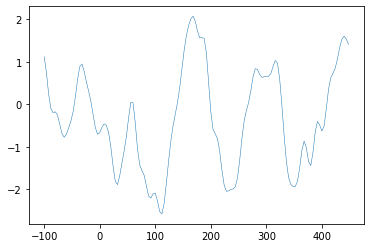

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesCount,Epoch_eeglab_ids,TOA_cond
22768,22768,32,Wn,T,5302,8,19,"[58, 297, 577, 657, 1313, 1471, 1685, 1896, 25...",T


In [8]:
## plot individual condition:
constraints = {
    'Subject':'32',
    'Vigilance':'Wn',
    "ToneHeight":'5302',
    "TrialPosition":'8',
    'TOA_cond':'T'}
conds_df, evoked_mat = getEvokedPerCondAndElectd(constraints,type='array')
mean_elect_epochs = np.nanmean(evoked_mat,axis=(0,1))
plt.plot(times,mean_elect_epochs,linewidth=0.5)
plt.show()
display(conds_df)

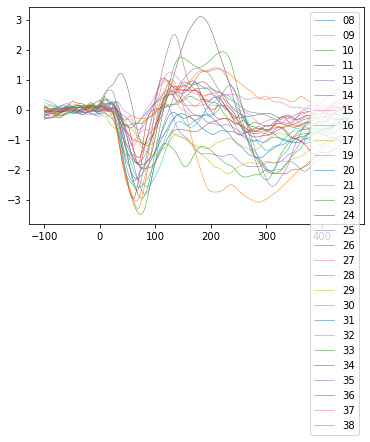

In [9]:
## plot all subs in a condition
for sub in cfg['subs']:
    conds_df, evoked_mat  = getEvokedPerCondAndElectd({'Subject':sub, 'Vigilance':'Wn','TOA_cond':'T'},type='array')
    mean_elect_epochs = np.nanmean(evoked_mat,axis=(0,1))
    plt.plot(times,mean_elect_epochs,label=sub,linewidth=0.5)
plt.legend()
plt.show()

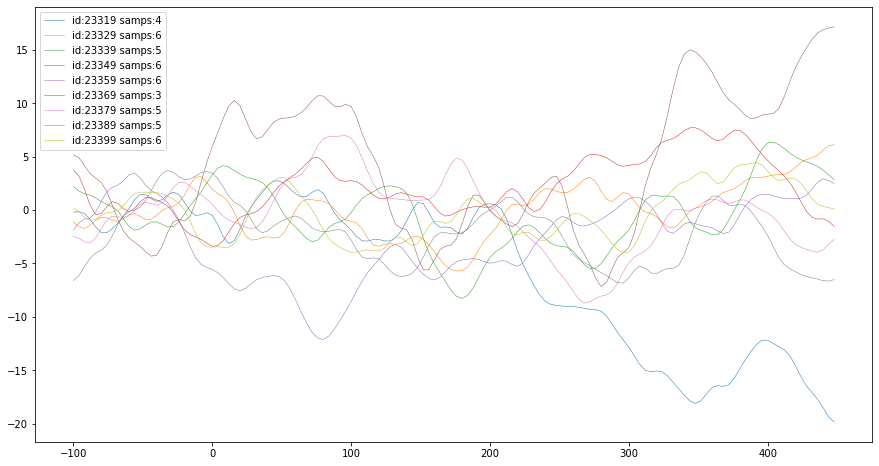

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesCount,Epoch_eeglab_ids,TOA_cond
23319,23319,32,N3,O,650,9,4,"[3280, 11557, 11765, 13715]",Fixed
23329,23329,32,N3,O,845,9,6,"[3185, 11469, 11750, 11816, 12940, 13643]",Fixed
23339,23339,32,N3,O,1098,9,5,"[3235, 11707, 11800, 13297, 13729]",Fixed
23349,23349,32,N3,O,1428,9,6,"[3260, 4901, 11483, 11631, 11875, 13748]",Fixed
23359,23359,32,N3,O,1856,9,6,"[3133, 4946, 11575, 11736, 11828, 13660]",Fixed
23369,23369,32,N3,O,2413,9,3,"[11611, 11649, 13628]",Fixed
23379,23379,32,N3,O,3137,9,5,"[3218, 4935, 11538, 11838, 13678]",Fixed
23389,23389,32,N3,O,4079,9,5,"[3152, 11595, 11689, 11906, 13697]",Fixed
23399,23399,32,N3,O,5302,9,6,"[3200, 11503, 11669, 11920, 12959, 13616]",Fixed


In [10]:
## plot all trials in cond
%matplotlib inline
#%matplotlib qt
df, epochs = getEvokedPerCondAndElectd({'Subject':'32'
                                ,'Vigilance':'N3'
                                ,'TOA_cond':'Fixed',
                                 },type='array')
labels = [f"id:{x} samps:{y}" for x,y in zip (df.Cond_id, df.SamplesCount)]
plt.figure(figsize=(15,8))
plt.plot(times,epochs[:,0,:].T,linewidth=0.5,label=labels)
plt.legend()
plt.show()
display(df)
df.to_excel(f'condDf__sub-32_vigi-N3_TOA-Rand.xlsx')

## NOTICE
It seems that all the events WnT1428_4 are encoded WnT1428_3.
Such that WnT1428_4 have 0 samples and WnT1428_3 double the normal amount

In [11]:
allEvents_df[(allEvents_df["ToneHeight"]=='1428') &
             (allEvents_df["Vigilance"]=='N2')&
             (allEvents_df["TOA"]=='T')&
             (allEvents_df["TrialPosition"]=='4')
             ]
#
# allEvents_df[(allEvents_df["ToneHeight"]=='1428') &
#              (allEvents_df["Vigilance"]=='Wn')&
#              (allEvents_df["TOA"]=='T')&
#              (allEvents_df["TrialPosition"]=='3')
#              ]

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesCount,Epoch_eeglab_ids,TOA_cond
304,304,08,N2,T,1428,4,67,"[617, 757, 875, 1129, 1321, 1459, 1636, 1966, ...",T
1384,1384,09,N2,T,1428,4,80,"[643, 973, 1114, 2221, 3360, 4259, 4502, 4644,...",T
2464,2464,10,N2,T,1428,4,82,"[493, 606, 793, 1715, 1975, 2073, 4194, 4478, ...",T
3544,3544,11,N2,T,1428,4,52,"[29, 166, 683, 3052, 3267, 3588, 3778, 3839, 4...",T
4624,4624,13,N2,T,1428,4,85,"[271, 468, 717, 888, 1257, 3650, 3796, 4034, 4...",T
5704,5704,14,N2,T,1428,4,23,"[341, 381, 462, 871, 1545, 3222, 3422, 4959, 5...",T
6784,6784,15,N2,T,1428,4,82,"[541, 855, 1115, 1308, 1346, 1680, 2123, 2237,...",T
7864,7864,16,N2,T,1428,4,82,"[991, 1090, 1349, 1449, 1667, 1977, 2535, 2765...",T
8944,8944,17,N2,T,1428,4,48,"[362, 557, 596, 811, 985, 1176, 1661, 1879, 20...",T
10024,10024,19,N2,T,1428,4,99,"[300, 557, 785, 1002, 1037, 1393, 1642, 1848, ...",T


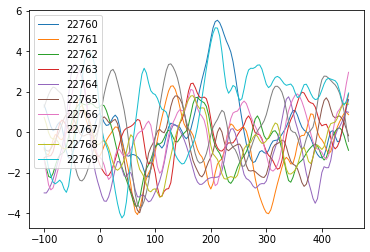

,Cond_id,Subject,Vigilance,TOA,ToneHeight,TrialPosition,SamplesCount,Epoch_eeglab_ids,TOA_cond
22760,22760,32,Wn,T,5302,0,23,"[42, 282, 561, 641, 960, 1140, 1297, 1455, 166...",T
22761,22761,32,Wn,T,5302,1,24,"[44, 284, 563, 643, 962, 1142, 1299, 1457, 167...",T
22762,22762,32,Wn,T,5302,2,23,"[46, 285, 565, 645, 964, 1144, 1301, 1459, 167...",T
22763,22763,32,Wn,T,5302,3,23,"[48, 287, 567, 647, 966, 1146, 1303, 1461, 167...",T
22764,22764,32,Wn,T,5302,4,24,"[50, 289, 569, 649, 968, 1148, 1305, 1463, 167...",T
22765,22765,32,Wn,T,5302,5,22,"[52, 291, 571, 651, 970, 1150, 1307, 1465, 167...",T
22766,22766,32,Wn,T,5302,6,22,"[54, 293, 573, 653, 972, 1152, 1309, 1467, 168...",T
22767,22767,32,Wn,T,5302,7,21,"[56, 295, 575, 655, 974, 1154, 1311, 1683, 213...",T
22768,22768,32,Wn,T,5302,8,19,"[58, 297, 577, 657, 1313, 1471, 1685, 1896, 25...",T
22769,22769,32,Wn,T,5302,9,12,"[978, 1158, 1473, 1898, 2136, 2232, 3161, 3419...",T


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[  42  282  561  641  960 1140 1297 1455 1669 1880 2118 2214 2543 2621
 2790 3103 3143 3401 3641 4118 4218 4335 4555]
[  44  284  563  643  962 1142 1299 1457 1671 1882 2120 2216 2545 2622
 2792 3105 3145 3403 3643 3841 4120 4220 4337 4557]
[  46  285  565  645  964 1144 1301 1459 1673 1884 2122 2218 2547 2624
 3107 3147 3405 3645 3843 4122 4222 4339 4559]
[  48  287  567  647  966 1146 1303 1461 1675 1886 2124 2220 2549 2795
 3109 3149 3407 3647 3845 4124 4224 4341 4561]
[  50  289  569  649  968 1148 1305 1463 1677 1888 2126 2222 2550 2627
 2797 3111 3151 3409 3649 3847 4126 4226 4343 4563]
[  52  291  571  651  970 1150 1307 1465 1679 1890 2128 2224 2552 2629
 2799 3113 3153 3651 3849 4128 4345 4565]
[  54  293  573  653  972 1152 1309 1467 1681 1892 2130 2226 2554 2631
 2801 3115 3413 3653 3851 4130 4229 4567]
[  56  295  575  655  974 1154 1311 1683 2132 2228 2556 2633 2803 3117
 3157 3415 3655 3853 4132 4231 4349]
[  58  297  577  657 1313 1471 1685 1896 2558 2635 2805 3119 3159 

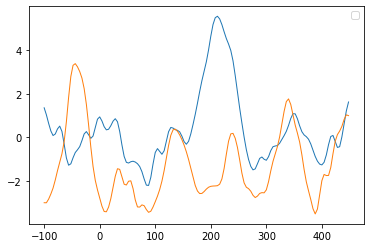

In [12]:
### I did same test in matlab for this condtion (sub 32, Wn, T5302_)
### and also in Import_eeglab_data

%matplotlib inline
#%matplotlib qt
df, epochs = getEvokedPerCondAndElectd({
    'Subject':'32'
    ,'Vigilance':'Wn'
    ,'TOA_cond':'T'
    ,"ToneHeight":cfg['toneHeights'][8]
     #,"TrialPosition":'6'
     },type='array')
plt.plot(times,epochs[:,0,:].T,linewidth=1,label=df.Cond_id)
plt.legend()
plt.show()

# plt.plot(times,epochs[0:-1:10,0,:].T,linewidth=0.5,label=df.Cond_id[0:-1:10])
# plt.legend()
# plt.show()
display(df)

a = df['Epoch_eeglab_ids'].to_numpy()
for a_ in a:
    print(a_)

mean_elect_currEpochs = np.nanmean(epochs,axis=1)

plt.plot(times,epochs[0,0,:],linewidth=1)
plt.plot(times,epochs[4,0,:],linewidth=1)

plt.legend()
plt.show()